In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('/Users/adarshnagia/Downloads/enhanced_sales_data.csv')
df.head()


,Date,Sales,Product Category,Region,Discount (%),Revenue ($)
0,2025-03-24,152,Toys,South,0,4727.92
1,2025-03-25,485,Clothing,West,15,8436.16
2,2025-03-26,398,Toys,West,29,13521.33
3,2025-03-27,320,Clothing,South,11,9354.41
4,2025-03-28,156,Electronics,East,4,7338.19


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.head()


,Sales,Product Category,Region,Discount (%),Revenue ($)
Date,,,,,
2025-03-24,152,Toys,South,0,4727.92
2025-03-25,485,Clothing,West,15,8436.16
2025-03-26,398,Toys,West,29,13521.33
2025-03-27,320,Clothing,South,11,9354.41
2025-03-28,156,Electronics,East,4,7338.19


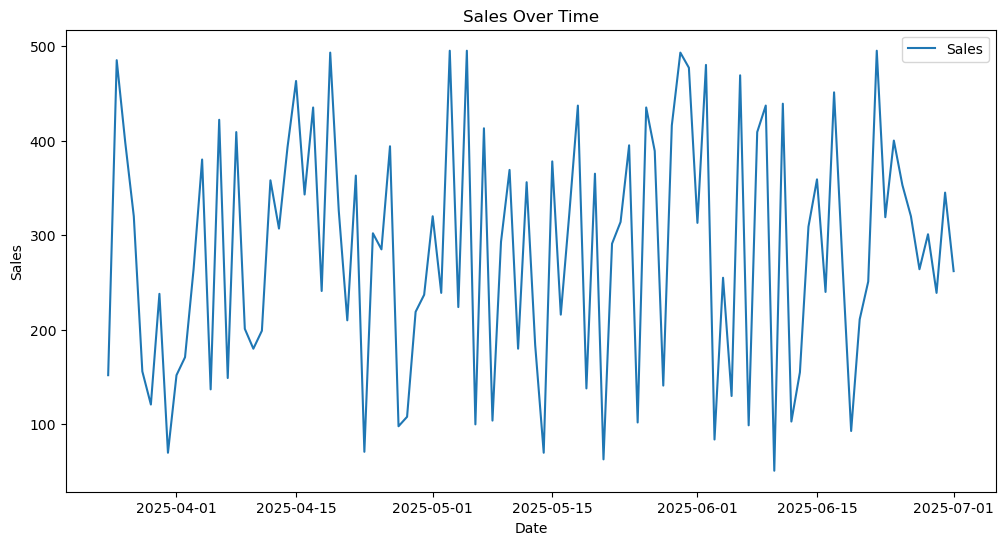

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


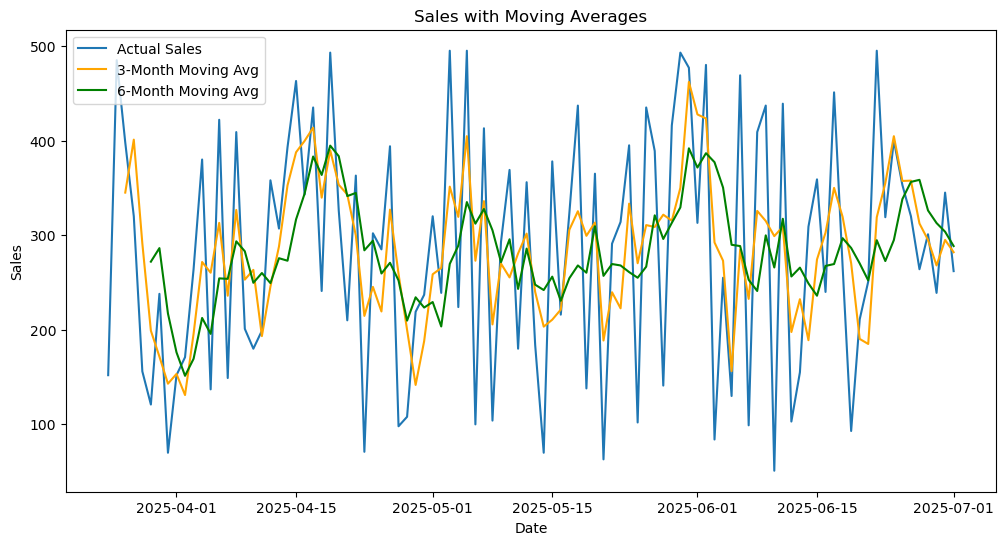

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Actual Sales')
plt.plot(df['Sales'].rolling(window=3).mean(), label='3-Month Moving Avg', color='orange')
plt.plot(df['Sales'].rolling(window=6).mean(), label='6-Month Moving Avg', color='green')
plt.title('Sales with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [15]:
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -6.065913175972407
p-value: 1.1819569119382053e-07


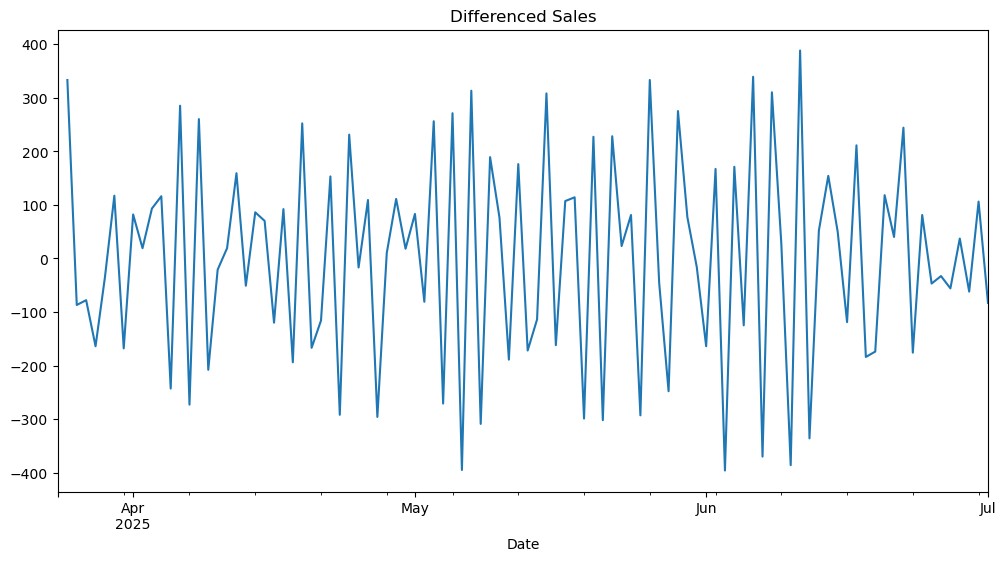

In [16]:
df['Sales_diff'] = df['Sales'].diff().dropna()
df['Sales_diff'].plot(figsize=(12,6), title='Differenced Sales')
plt.show()


In [17]:
train = df.iloc[:-12]
test = df.iloc[-12:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (88, 6)
Test shape: (12, 6)


In [21]:
import warnings
warnings.filterwarnings("ignore")

# Make sure frequency is set
df = df.asfreq(pd.infer_freq(df.index))

# Fit SARIMAX
model = SARIMAX(
    train['Sales'],
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13841D+00    |proj g|=  7.79677D-02

At iterate    5    f=  6.10721D+00    |proj g|=  5.45287D-02

At iterate   10    f=  6.10537D+00    |proj g|=  7.20086D-03

At iterate   15    f=  6.10445D+00    |proj g|=  9.93241D-02

At iterate   20    f=  6.10144D+00    |proj g|=  2.70459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     34      1     0     0   7.353D-06   6.101D+00
  F =   6.1014379891952268     

CONVERG

 This problem is unconstrained.


In [22]:
forecast = results.get_forecast(steps=12)
forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.index = test.index

forecast_df.head()


,lower Sales,upper Sales,Forecast
Date,,,
2025-06-20,63.313505,580.302612,321.808058
2025-06-21,8.607876,536.256990,272.432433
2025-06-22,18.883462,547.291426,283.087444
2025-06-23,16.595383,544.980909,280.788146
2025-06-24,17.085851,545.482795,281.284323


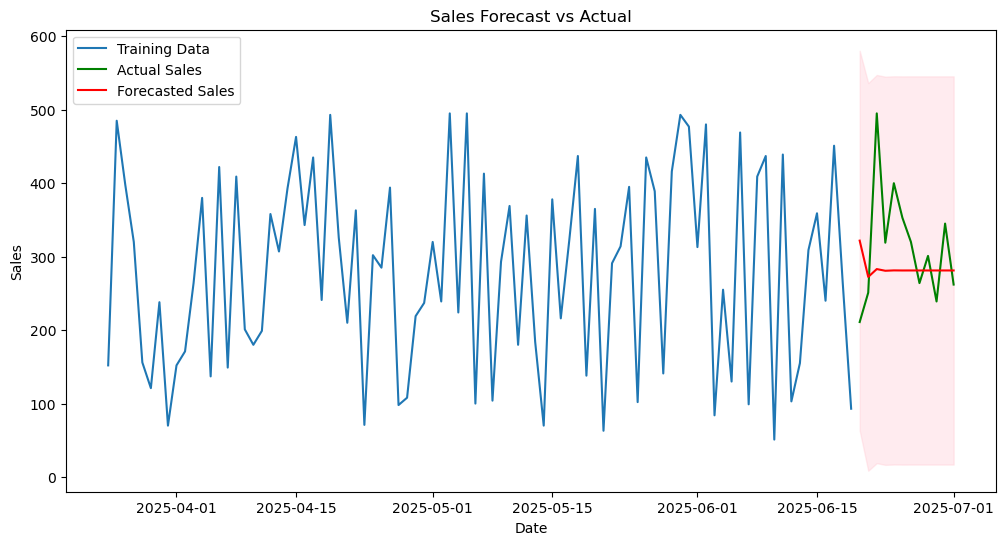

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Training Data')
plt.plot(test['Sales'], label='Actual Sales', color='green')
plt.plot(forecast_df['Forecast'], label='Forecasted Sales', color='red')
plt.fill_between(
    forecast_df.index,
    forecast_df['lower Sales'],
    forecast_df['upper Sales'],
    color='pink', alpha=0.3
)
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [24]:
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast_df['Forecast']))
mae = mean_absolute_error(test['Sales'], forecast_df['Forecast'])

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


RMSE: 85.03
MAE: 64.49


In [25]:
forecast_df[['Forecast']].to_csv('forecasted_sales.csv')
forecast_df.head()


,lower Sales,upper Sales,Forecast
Date,,,
2025-06-20,63.313505,580.302612,321.808058
2025-06-21,8.607876,536.256990,272.432433
2025-06-22,18.883462,547.291426,283.087444
2025-06-23,16.595383,544.980909,280.788146
2025-06-24,17.085851,545.482795,281.284323
